In [1]:
import root_numpy
import pandas as pd
import numpy as np
import numpy.linalg as la
import copy
import pickle
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

/home/vbelavin/home/anaconda3/envs/rootenv/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.14.2 is currently installed but you installed root_numpy against numpy 1.12.1. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
from tools.opera_tools import combine_mc_bg, gen_graphx, gen_x_y_dataset, load_bg, load_mc
from create_graph.create_graph import create_graph

In [3]:
def test_quality(graphx: nx.DiGraph, shower: int = 1):
    nodes_ids_shower = []
    degrees = graphx.degree()
    for node_id, node in graphx.nodes(data=True):
        if node['signal'] == shower:
            nodes_ids_shower.append(node_id)
    subgraphx_shower_pre = graphx.subgraph(nodes_ids_shower)
    
    degrees = subgraphx_shower_pre.degree()
    
    degrees_array = []
    for node_id, d in degrees:
        degrees_array.append(d)
    degrees_array = np.array(degrees_array)
    ratio_of_zero_nodes = np.unique(degrees_array, return_counts=True)[1][0] / len(subgraphx_shower_pre)
    mean_density = np.mean(degrees_array)
    median_density = np.median(degrees_array)
    connected_comp_per_node = nx.number_connected_components(nx.Graph(subgraphx_shower_pre)) / len(subgraphx_shower_pre)
    return ratio_of_zero_nodes, mean_density, median_density, connected_comp_per_node

In [5]:
slopes = np.linspace(0.01, 0.15, 10)
r_maxs = np.linspace(100, 600, 11)

## For shower

Take one shower and look at data stats such as mean node degree, ratio of connected components to number of nodes etc...

In [6]:
%%time
pbg = load_bg(filepath='./data/', step=20000)
pmc = load_mc(filename='./data/mcdata_taue2.root', step=1)

idx_len_greater_100 = list()
for i in range(len(pmc)):
    if len(pmc.iloc[i]['BT_X']) > 300:
        idx_len_greater_100.append(pmc.iloc[i].Event_id)

stats_shower = dict()
for r_max in r_maxs:
    print(r_max)
    for slope in slopes:
        print(slope)
        ratio_of_zero_nodes_list, mean_density_list, median_density_list, num_conn_comp_list = [], [], [], []
        for i in range(100):
            train = combine_mc_bg(pmc, pbg, events=[idx_len_greater_100[i]], bg_frac=1)
            train = train.reset_index()
            train['index'] = train.index.values
            edges = create_graph(train[['index', 'sx', 'sy', 'sz', 'TX', 'TY']].values, slope, r_max)
            train_np = train[['index', 'sx', 'sy', 'sz', 'TX', 'TY', 'chi2', 'signal']].values
            graphx = gen_graphx(train_np, edges, r_max)
            ratio_of_zero_nodes, mean_density, median_density, connected_comp_per_node = test_quality(graphx, shower=1)
            ratio_of_zero_nodes_list.append(ratio_of_zero_nodes)
            mean_density_list.append(mean_density)
            median_density_list.append(median_density)
            num_conn_comp_list.append(connected_comp_per_node) 
        stats_shower[(r_max, slope)] = (ratio_of_zero_nodes_list, mean_density_list, median_density_list, num_conn_comp_list)

TClass::Init:0: RuntimeWarning: no dictionary for class EdbPoint2D is available
TClass::Init:0: RuntimeWarning: no dictionary for class EdbPoint is available
TClass::Init:0: RuntimeWarning: no dictionary for class EdbTrack2D is available
TClass::Init:0: RuntimeWarning: no dictionary for class EdbAngle2D is available
TClass::Init:0: RuntimeWarning: no dictionary for class EdbSegCouple is available
TClass::Init:0: RuntimeWarning: no dictionary for class EdbSegP is available
TClass::Init:0: RuntimeWarning: no dictionary for class EdbID is available


bg: 1390 tracks
numtracks reduction by cuts:  [18724, 18679, 9616, 9106]
len(pmc): 9106
100.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.08777777777777776
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
150.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.08777777777777776
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
200.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
250.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.08777777777777776
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
300.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.08777777777777776
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
350.0
0.01
0.025555555555555554
0.041

In [7]:
stats_slope_shower = defaultdict(lambda: defaultdict(list))
for key in stats_shower.keys():
    stats_slope_shower[key[1]]['zeros'].append(
        np.mean(stats_shower[key][0])
    )
    stats_slope_shower[key[1]]['med_dens'].append(
        np.mean(stats_shower[key][2])
    )
    stats_slope_shower[key[1]]['mean_dens'].append(
        np.mean(stats_shower[key][1])
    )
    stats_slope_shower[key[1]]['mean_conn'].append(
        np.mean(np.array(stats_shower[key][3]))
    )
    stats_slope_shower[key[1]]['r'].append(key[0])

## Background

In [8]:
%%time
### difference
pbg = load_bg(filepath='./data/', step=10)
pmc = load_mc(filename='./data/mcdata_taue2.root', step=1)

idx_len_greater_100 = list()
for i in range(len(pmc)):
    if len(pmc.iloc[i]['BT_X']) > 300:
        idx_len_greater_100.append(pmc.iloc[i].Event_id)
print(len(idx_len_greater_100))


stats_background = dict()
for r_max in r_maxs:
    print(r_max)
    for slope in slopes:
        print(slope)
        ratio_of_zero_nodes_list, mean_density_list, median_density_list, num_conn_comp_list = [], [], [], []
        for i in range(1):
            ### difference
            train = combine_mc_bg(pmc, pbg, events=[], bg_frac=1)
            train = train.reset_index()
            train['index'] = train.index.values
            edges = create_graph(train[['index', 'sx', 'sy', 'sz', 'TX', 'TY']].values, slope, r_max)
            train_np = train[['index', 'sx', 'sy', 'sz', 'TX', 'TY', 'chi2', 'signal']].values
            graphx = gen_graphx(train_np, edges, r_max)
            ### difference
            ratio_of_zero_nodes, mean_density, median_density, connected_comp_per_node = test_quality(graphx, shower=0)
            ratio_of_zero_nodes_list.append(ratio_of_zero_nodes)
            mean_density_list.append(mean_density)
            median_density_list.append(median_density)
            num_conn_comp_list.append(connected_comp_per_node) 
        stats_background[(r_max, slope)] = (ratio_of_zero_nodes_list, mean_density_list, median_density_list, num_conn_comp_list)

bg: 2732232 tracks
numtracks reduction by cuts:  [18724, 18679, 9616, 9106]
len(pmc): 9106
5074
100.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.08777777777777776
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
150.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.08777777777777776
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
200.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.08777777777777776
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
250.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.08777777777777776
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
300.0
0.01
0.025555555555555554
0.041111111111111105
0.056666666666666664
0.07222222222222222
0.08777777777777776
0.10333333333333332
0.11888888888888886
0.13444444444444442
0.15
350.0
0.0

In [10]:
stats_slope_background = defaultdict(lambda: defaultdict(list))
for key in stats_background.keys():
    stats_slope_background[key[1]]['zeros'].append(
        np.mean(stats_background[key][0])
    )
    stats_slope_background[key[1]]['med_dens'].append(
        np.mean(stats_background[key][2])
    )
    stats_slope_background[key[1]]['mean_dens'].append(
        np.mean(stats_background[key][1])
    )
    stats_slope_background[key[1]]['mean_conn'].append(
        np.mean(np.array(stats_background[key][3]))
    )
    stats_slope_background[key[1]]['r'].append(key[0])

## Plot everything!

In [11]:
def plot_stats(shower_stats, noise_stats):
    plt.figure(figsize=(16, 16))
    plt.title('zero ratio')
    for slope in slopes:
        plt.plot(shower_stats[slope]['r'], shower_stats[slope]['zeros'], label='shower '+str(slope))
        plt.plot(noise_stats[slope]['r'], noise_stats[slope]['zeros'], label='noise '+str(slope))
    plt.legend()
    plt.show()

    plt.figure(figsize=(16, 16))
    plt.title('median degree')
    for slope in slopes:
        plt.plot(shower_stats[slope]['r'], shower_stats[slope]['med_dens'], label='shower '+str(slope))
        plt.plot(noise_stats[slope]['r'], noise_stats[slope]['med_dens'], label='noise '+str(slope))
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(16, 16))
    plt.title('mean degree')
    for slope in slopes:
        plt.plot(shower_stats[slope]['r'], shower_stats[slope]['mean_dens'], label='shower '+str(slope))
        plt.plot(noise_stats[slope]['r'], noise_stats[slope]['mean_dens'], label='noise '+str(slope))
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(16, 16))
    plt.title('mean connectivity per nodes')
    for slope in slopes:
        plt.plot(shower_stats[slope]['r'], shower_stats[slope]['mean_conn'], label='shower '+str(slope))
        plt.plot(noise_stats[slope]['r'], noise_stats[slope]['mean_conn'], label='noise '+str(slope))
    plt.legend()
    plt.show()

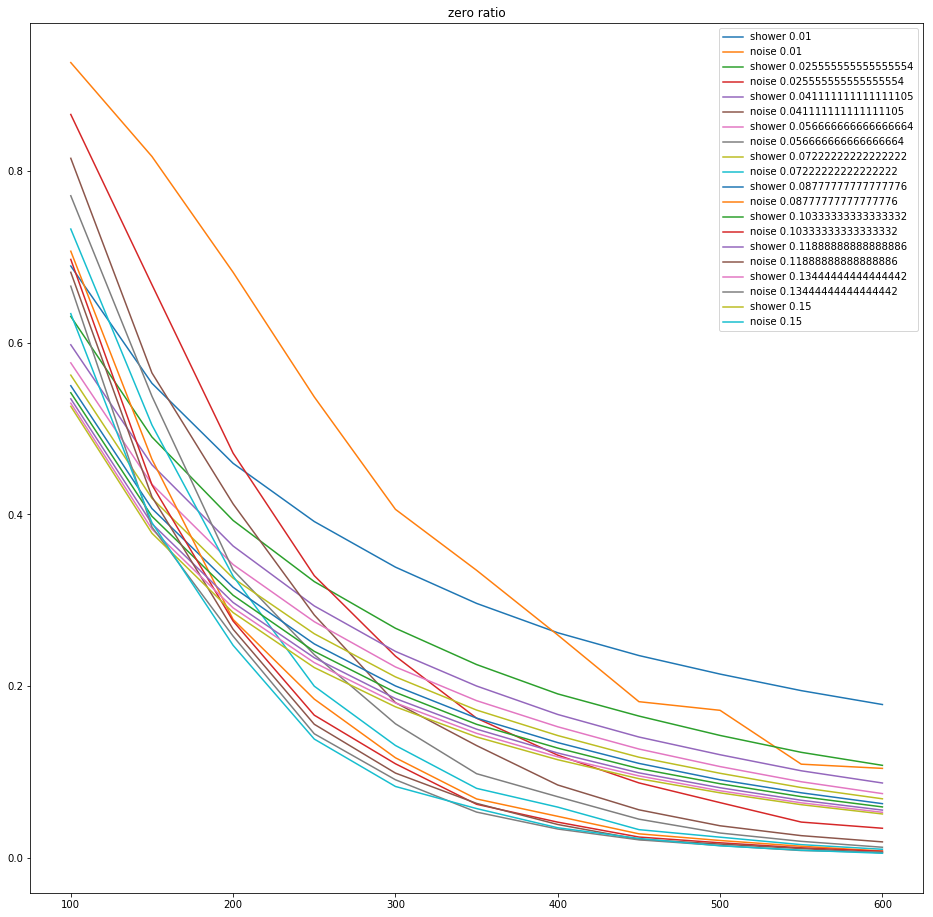

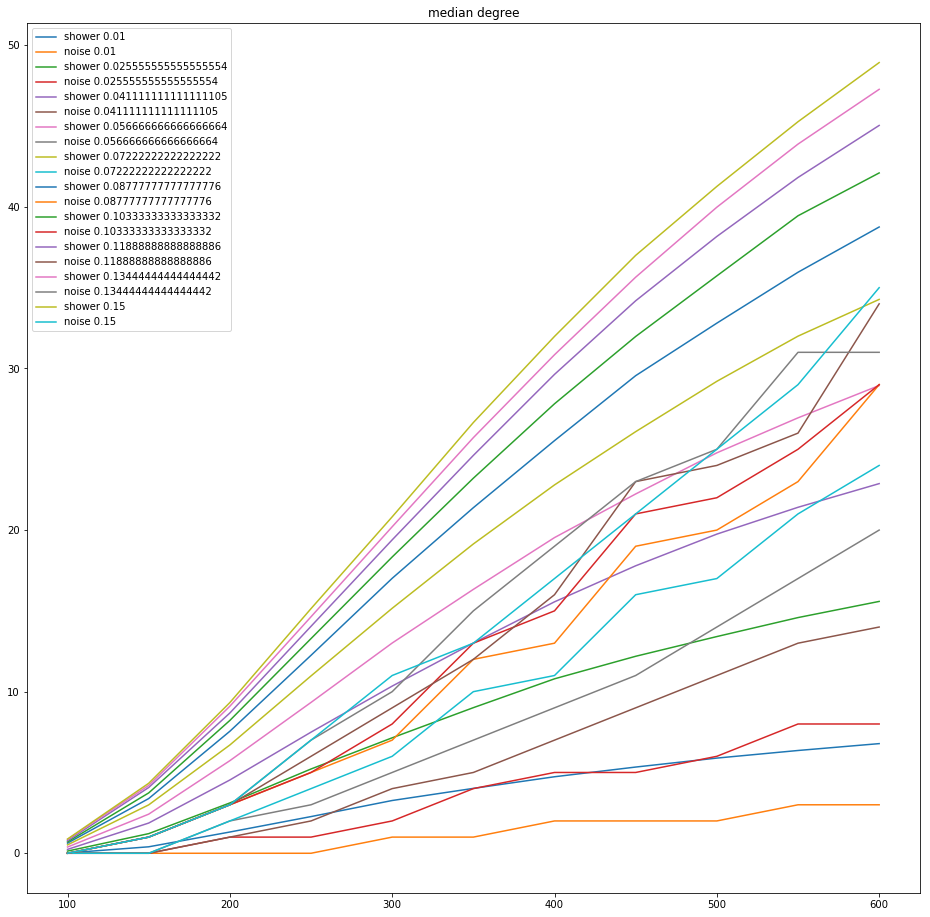

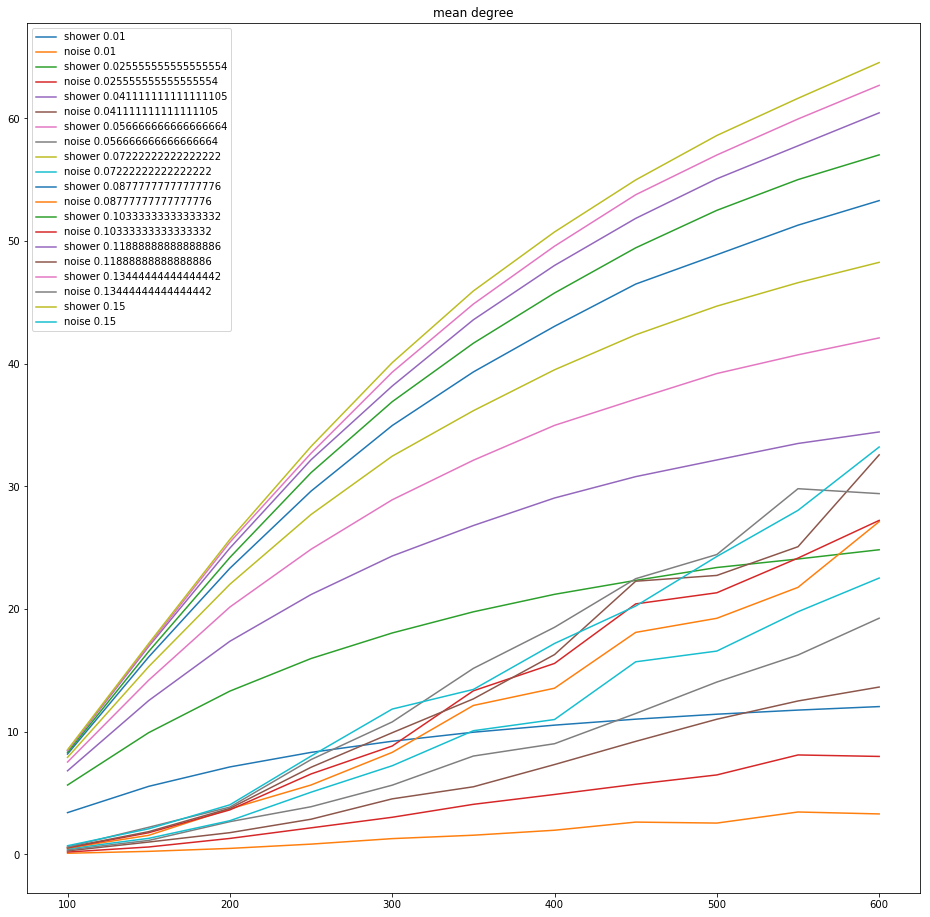

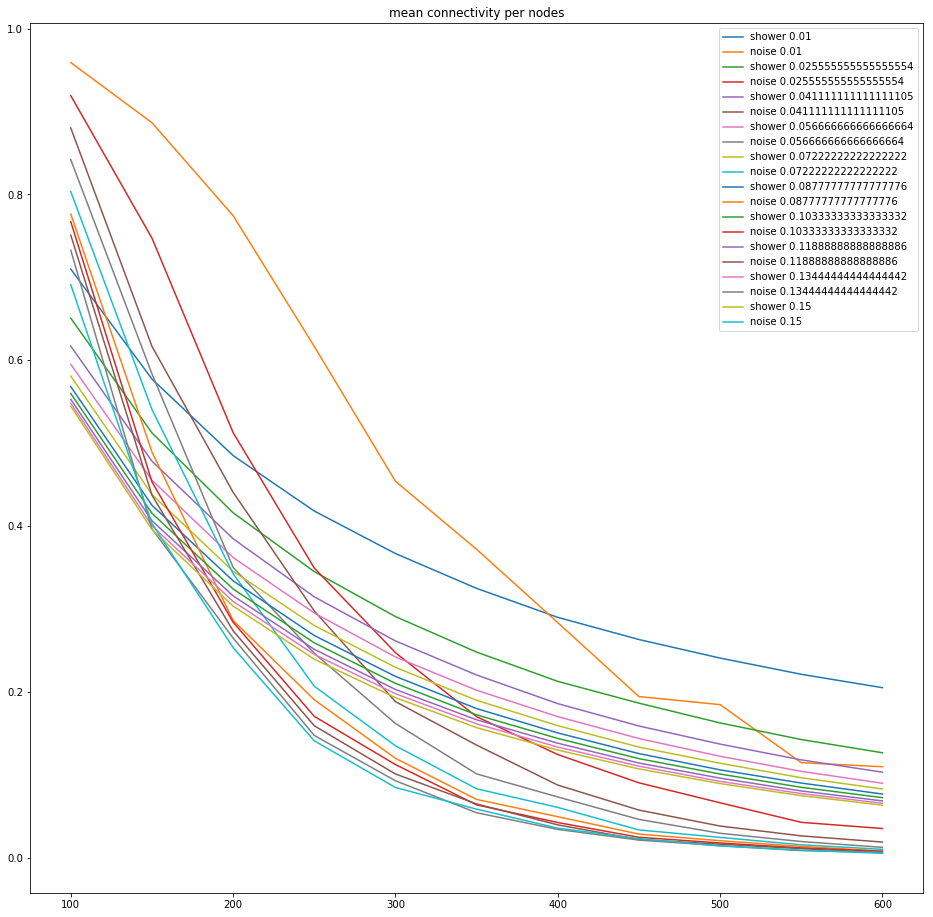

In [12]:
plot_stats(stats_slope_shower, stats_slope_background)

In [16]:
1

1